# Identify land use from satellite images using Convolutional Neural Networks - Part 2
## *Improve Performance with Data Augmentation*

The goal of this notebook is to improve the generalization performance of the CNN model for land use identification using data augmentation. Data augmentation involves applying random transformations to the training data, such as rotations, flips, and translations. These transformations increase the diversity of the training dataset and help the model learn more robust features.

The walktrough in this notebook will show you how to perform and visualize data augmentation for the training dataset. Follow along with the steps outlined in this section until its conclusion. At the end of the walkthrough, you are asked to create your own data augmentation pipeline, re-create the augmented datasets and then train, validate and test to assess the benefits of data augumentation.


## Walkthrough

### Load modules and connect to Google Drive

In [1]:
# Import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
from torchsummary import summary

from sklearn.model_selection import train_test_split

In [2]:
# Connect to Google Colab
from google.colab import drive

# This will prompt for authorization to access your Google Drive from Colab.
drive.mount('/content/drive', force_remount=True)

# After mounting, you can navigate to a specific folder using the usual UNIX cd command.
# Replace 'your_folder_path' with the actual path of your folder inside Google Drive.
folder_path = '/content/drive/MyDrive/Teaching/DSAIE/UNIT2/CNN/'  # Example path
%cd "$folder_path"

Mounted at /content/drive
/content/drive/MyDrive/Teaching/DSAIE/UNIT2/CNN


In [3]:
# Check if CUDA is available, otherwise use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


### Load list of images and labels

In [4]:
# Load CSV file and subsample (sample_size==-1 for full dataset)
sample_size = 500
if sample_size == -1:
  df = pd.read_csv('./data/USMerced_LandUse/labels.csv')
else:
  df = pd.read_csv('./data/USMerced_LandUse/labels.csv').sample(sample_size, random_state=42)

# Get image file paths and labels
image_paths = df['image'].values
labels = df['label'].values
num_classes = 21 # We specify the max number of classes in the dataset, regardless of the initial subsampling
print(f'Loaded {len(image_paths)} images, with {num_classes} different classes.')

# Load the mapping between integer labels and class names
label_mapping = {}
with open('./data/USMerced_LandUse/label_mapping.txt', 'r') as file:
    for line in file:
        value, key = line.strip().split(': ')
        label_mapping[int(key)] = value

print(label_mapping)

Loaded 500 images, with 21 different classes.
{0: 'agricultural', 1: 'airplane', 2: 'baseballdiamond', 3: 'beach', 4: 'buildings', 5: 'chaparral', 6: 'denseresidential', 7: 'forest', 8: 'freeway', 9: 'golfcourse', 10: 'harbor', 11: 'intersection', 12: 'mediumresidential', 13: 'mobilehomepark', 14: 'overpass', 15: 'parkinglot', 16: 'river', 17: 'runway', 18: 'sparseresidential', 19: 'storagetanks', 20: 'tenniscourt'}


In [5]:
# Split the data (adjust the test_size according to your needs)
train_paths, test_paths, original_train_labels, test_labels = train_test_split(
    image_paths, labels, test_size=0.30, random_state=42)

val_paths, test_paths, val_labels, test_labels = train_test_split(
    test_paths, test_labels, test_size=0.5, random_state=42)

### Load the original train dataset

In [6]:
def load_images(file_paths, transform, folder_path='./data/USMerced_LandUse/Images/'):
    images = []
    for file_path in tqdm(file_paths, desc='Loading images'):
        # Load the image
        with Image.open(folder_path+file_path) as img:
            # Convert image to RGB if it's not and apply the same basic transformations
            img = img.convert('RGB')
            img = transform(img)
            images.append(img)
    return torch.stack(images)

def calculate_mean_std(stacked_images):
    # Mean and std are calculated across the height and width dimensions (2 and 3)
    mean = stacked_images.view(stacked_images.size(0), stacked_images.size(1), -1).mean(dim=2).mean(dim=0)
    std = stacked_images.view(stacked_images.size(0), stacked_images.size(1), -1).std(dim=2).mean(dim=0)
    return mean, std

# Basic image transformations to load the training dataset
basic_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Load images for the mean/std calculation
original_train_images = load_images(train_paths, basic_transform)

# Calculate mean and std
mean, std = calculate_mean_std(original_train_images)

# Create the normalization transform using mean and std
normalize_transform = transforms.Normalize(mean=mean, std=std)

# Apply the normalization to each original training image
original_train_images = torch.stack([normalize_transform(image) for image in original_train_images])

Loading images: 100%|██████████| 350/350 [03:28<00:00,  1.68it/s]


### Create and test the augmentation pipeline

In [7]:
# Define your augmentation pipeline
transformation_pipeline = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.GaussianBlur(kernel_size=(3, 9), sigma=(0.1, 2)),
    transforms.Resize((224, 224), antialias=True)
])

# Function to augment the images (excluding the original images)
def augment_images(image_set, labels, num_augmentations=3):
    augmented_images = []
    augmented_labels = []
    for orig_img, label in zip(image_set, labels):
        for _ in range(num_augmentations):
            # Apply the augmentation and add the new image
            augmented_images.append(transformation_pipeline(orig_img))
            augmented_labels.append(label)
    return torch.stack(augmented_images), torch.Tensor(augmented_labels)

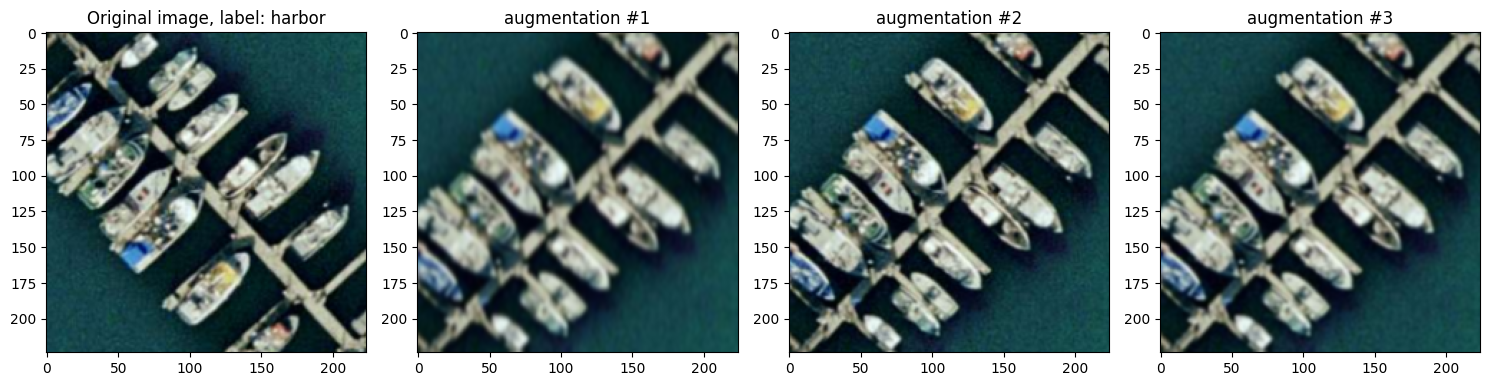

In [8]:
def denormalize(image_tensor, mean, std):
    # Denormalize the image
    denorm_img = image_tensor * std[:, None, None] + mean[:, None, None]
    # Clip values to be between 0 and 1
    denorm_img = denorm_img.clip(0, 1)
    return denorm_img

# Test augmentation
ix_to_augment = 5   # sample image to augment
img_to_augment = original_train_images[ix_to_augment]
lbl_to_augment = original_train_labels[ix_to_augment]

# number of augmentations
num_augmentations = 3
augmented_images, augmented_labels = augment_images([img_to_augment], [lbl_to_augment], num_augmentations)
f, axes = plt.subplots(1,num_augmentations+1, figsize=(15,4))

# Visualize original image
axes[0].imshow(denormalize(img_to_augment, mean, std).numpy().transpose((1, 2, 0)))   # Denormalize and transpose the tensor to [height, width, channels]
axes[0].set_title(f"Original image, label: {label_mapping[lbl_to_augment]}")

# Visualize augmentations
for ix, (ax, tensor) in enumerate(zip(axes[1:], augmented_images)):
  # Denormalize and transpose the tensor to [height, width, channels]
  image = denormalize(tensor, mean, std).numpy().transpose((1, 2, 0))
  # Plotting
  ax.imshow(image)
  ax.set_title(f"augmentation #{ix+1}")

f.tight_layout()
f.show()

### Augment the Training Dataset

In [9]:
# Choose whether to augment or not your dataset
do_augmentation = True

if do_augmentation:
  # Augment the train_images dataset
  num_augmentations = 3
  # Stack the original train images with the augmented ones
  augmented_train_images, augmented_train_labels = augment_images(original_train_images, original_train_labels, num_augmentations)
  augmented_train_images = torch.cat((original_train_images, augmented_train_images), dim=0)
  augmented_train_labels = torch.cat((torch.Tensor(original_train_labels), augmented_train_labels), dim=0).to(torch.long)
else:
  # ... or use the original train images
  augmented_train_images = original_train_images
  augmented_train_labels = torch.tensor(original_train_labels)

### Load and normalize Validation and Test Dataset

In [10]:
# Transformation with normalization for validation and test dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

# Load and normalize the validation and test datasets
val_images = load_images(val_paths, transform)
test_images = load_images(test_paths, transform)

# Convert labels to tensors
val_labels = torch.tensor(val_labels)
test_labels = torch.tensor(test_labels)

# Create TensorDatasets
train_dataset = TensorDataset(augmented_train_images, augmented_train_labels)
val_dataset = TensorDataset(val_images, val_labels)
test_dataset = TensorDataset(test_images, test_labels)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Loading images: 100%|██████████| 75/75 [00:38<00:00,  1.96it/s]


## Assignments

1. Go back and **create your own augmentation pipeline**. Discuss with your fellow students what choices could be beneficial and what could be detrimental.
2. Add the CNN model and a training loop with early stopping (or just save the best model whenever your performance improve); for this step you can simply copy paste from your version of the notebook *Identify land use from satellite images using Convolutional Neural Networks - Part 1*  
3. Test the performance on the test dataset.
4. Redo the experiment without data augmentation to check whether it was beneficial. To do so, set `do_augmentation = False` a few cells above.
